In [5]:
from exp_scripts import experiments_path

In [6]:
import logging
import os
from pathlib import Path
import re
import json
from typing import Any
from pydantic import BaseModel
from scipy.stats import gaussian_kde
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from exp_scripts import experiments_path


In [2]:
cases = [1, 2, 3, 4, 5, 6]
methods = ['overlapschedule', 'randomallocation', 'maxduration']

In [6]:
def read_data_to_df(files: list[Path], cols: dict[str, Any], ignore_missing:bool =False) -> pd.DataFrame:

    raw_data: list[dict[str, int|float|str]] = []

    for file_name in files:
        data = get_data_from_file(file_name)
        if not data:
            logging.warning(f"Could not read {file_name}.")
            continue

        exp_info = get_experiment_info(file_name.stem)

        raw_data.append(exp_info.dict())

        stats = data["statistics"]

        for col, default in cols.items():
            if col in stats:
                raw_data[-1][col] = stats[col]
            elif ignore_missing:
                pass
            else:
                raw_data[-1][col] = default
                # raise ValueError(f"{file_name} has no data about {col}.")


    df = pd.DataFrame(raw_data)

    return df

def get_data_from_file(file_name: Path):
    try:
        with open(file_name) as json_file:
            data = json.load(json_file)
    except json.decoder.JSONDecodeError as e:
        print(e)
        print(file_name)
        return None
    return data


class ExperimentInfo(BaseModel):
    case_number: int
    schedule_seed: int
    dist_seed: int
    sim_seed: int
    answer_seed: int
    method_name: str
    det_job: bool


def get_experiment_info(file_stem: str) -> ExperimentInfo:
    # sched_case_1_method_maxduration_dist_seed_0_schedule_seed_0_sim_seed_0_det_job_False_answer_seed_0

    # Use regular expression to extract the number of the case
    case_number = int(re.search(r'case_(\d+)', file_stem).group(1))
    schedule_seed = int(re.search(r'schedule_seed_(\d+)', file_stem).group(1))
    dist_seed = int(re.search(r'dist_seed_(\d+)', file_stem).group(1))
    sim_seed = int(re.search(r'sim_seed_(\d+)', file_stem).group(1))
    answer_seed = re.search(r'answer_seed_(\d+)', file_stem)
    det_job = True if file_stem.split("job")[-1].split("_")[1] == 'True' else False
    if answer_seed is None:
        answer_seed = sim_seed
    else:
        answer_seed = int(answer_seed.group(1))
    method = file_stem.split("method")[-1].split("_")[1]
    return ExperimentInfo(case_number=case_number, schedule_seed=schedule_seed, dist_seed=dist_seed, sim_seed=sim_seed,
                          answer_seed=answer_seed, method_name=method, det_job=det_job)

def set_density(ax, data, first=False):
    n_bins = 30

    color = ['red', 'blue', 'green', 'orange', 'black']

    ax.hist(data, n_bins, density=True, histtype='bar', color=color[:len(data)])
    xs = np.linspace(min(min(makespan) for makespan in data), max(max(makespan) for makespan in data), 20)

    for i, case in enumerate(data):
        density_re = gaussian_kde(case.tolist())
        density_re.covariance_factor = lambda: .50
        density_re._compute_covariance()
        ax.plot(xs, density_re(xs), "--", color=color[i])

    return ax, max(density_re(xs))

In [4]:
folder_path = os.path.join(experiments_path, 'base_sched_2024-03-05/base_sched/')
extracted_files = os.listdir(folder_path)
extracted_files = [Path(folder_path+file) for file in extracted_files if '.json' in file and '.ipynb' not in file]
df = read_data_to_df(extracted_files, {"makespan": -1, "FAIL": False})

Expecting ',' delimiter: line 1 column 7166 (char 7165)
/home/username/PycharmProjects/online_scheduling/exp_scripts/experiments/base_sched_2024-03-05/base_sched/sched_case_3_method_maxduration_dist_seed_3_schedule_seed_20_sim_seed_0_det_job_False_answer_seed_0.json


/tmp/ipykernel_466251/3384095562.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df[df["FAIL"] == False][df["case_number"] == case][df["sim_seed"] == 0][
/tmp/ipykernel_466251/3384095562.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df[df["FAIL"] == False][df["case_number"] == case][df["sim_seed"] == 0][
/tmp/ipykernel_466251/3384095562.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df[df["FAIL"] == False][df["case_number"] == case][df["sim_seed"] == 0][
/tmp/ipykernel_466251/3384095562.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df[df["FAIL"] == False][df["case_number"] == case][df["sim_seed"] == 0][
/tmp/ipykernel_466251/3384095562.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df[df["FAIL"] == False][df["case_number"] == case][df["sim_seed"] == 0][
/tmp/ipykernel_46625

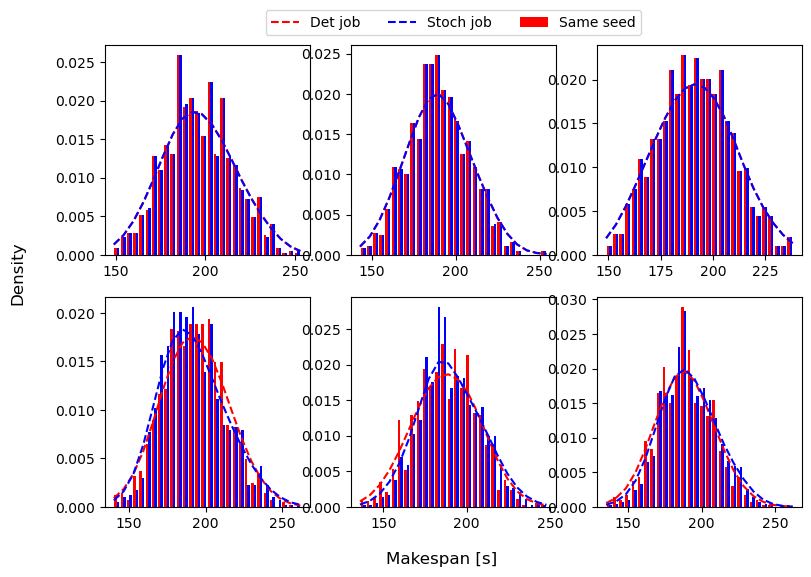

In [7]:
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
axes = [ax0, ax1, ax2, ax3, ax4, ax5]

for case, ax in zip(cases, axes):
    for method in methods:
        if method == 'overlapschedule':
            df1 = df[df["FAIL"] == False][df["case_number"] == case][df["sim_seed"] == 0][
                df["schedule_seed"] == 0][df['method_name'] == method][df['dist_seed'] == 0][df['det_job'] == True]

            df2 = df[df["FAIL"] == False][df["case_number"] == case][df["sim_seed"] == 0][
                df["schedule_seed"] != 0][df['method_name'] == method][df['det_job'] == True]

            df3 = df[df["FAIL"] == False][df["case_number"] == case][df["sim_seed"] == 0][
                df["schedule_seed"] != 0][df['method_name'] == method][df['det_job'] == False]

            # makespan_time_knowledge = df1.at[df1.index[-1], "makespan"][1]

            det_job_makespan: list[int] = np.array(list((df2.get("makespan"))))[:, 1]
            stoch_job_makespans_other: list[int] = np.array(list((df3.get("makespan"))))[:, 1]
            _, ymax = set_density(ax, [det_job_makespan, stoch_job_makespans_other])
            # ax.vlines(makespan_time_knowledge, ymin=0, ymax=ymax, color='red')
        else:
            pass
            # df2 = df[df["FAIL"] == False][df["case_number"] == case][df["dist_seed"] == 0][df['method_name'] == method]


# Set common labels
fig.supxlabel('Makespan [s]')
fig.supylabel('Density')
ax1.legend(['Det job', 'Stoch job', 'Same seed'], ncol=3, loc='upper center',bbox_to_anchor=(0.5, 1.2))
# fig.tight_layout()
plt.show()